In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

%matplotlib inline

In [2]:
# Here I am creating so helper functions to help with parsing out our text
def clean_soup(soup):
    for tag in soup.find_all(['script', 'style','meta']):
        tag.decompose()   
    return soup.get_text()


def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


In [3]:
import os

# This is the hard coded directory in which the raw html lives on my computer
rootdir = '/home/roland/Workspace/Data/Procrastinating_HTML/'
# Here we are creating a data frame to store the classified information in
data = pd.DataFrame(columns = ['activity', 'text', 'timestamp'])

# These strings were placed into the HTML by my browser extension to hold onto store the url
URL_STRING = "__URL__: "
HTML_START = "<"

for subdir, dirs, files in os.walk(rootdir):
    i = 0
    for file in files:
        f = open(os.path.join(subdir, file))
        raw = f.read()
        url = ''
        # Parsing out the URL string if it exists
        if URL_STRING in raw:
            url = find_between(raw, URL_STRING, HTML_START)
            raw = raw.replace(url, '')
        
        # Below are characters I am manually parsing out. There must exist a more efficient way to do this
        # but for now it runs fast enough.
        raw = raw.replace('\n', ' ')
        raw = raw.replace('\t', ' ')
        raw = raw.replace('\\n', ' ')
        raw = raw.replace('\\t', ' ')
        raw = raw.replace(URL_STRING, '')

        soup = BeautifulSoup(raw)
        data.set_value(i, 'text', clean_soup(soup))
        t = str(file).split('_')
        data.set_value(i, 'activity', t[0])
        timestamp = t[1].split('.')[0]
        data.set_value(i, 'timestamp', timestamp)
        data.set_value(i, 'url', url)
        i+=1
        f.close()


/home/roland/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/roland/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [4]:
data=data[data.text != ""]

In [5]:
data.timestamp = data.timestamp.str.replace("\(1\)","")
data.timestamp = data.timestamp.str.replace("T","-")

In [6]:
X = data[['text','url']]

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, data.activity,test_size=0.33, random_state=43)

In [7]:
data.to_csv('parsed_html.csv', index=False)

## Model building

#### Building a grid searched pipeline

I am using a grid search over a pipeline to find the best model to use. After much trial and error I settled on a logistic regression model. First off it simply performaned the best. But additionally it is by far the most interpretible model. Also, Lasso Regularization is a great way to reduce the number of features generated by the countvectorization process, and the use of ngrams. At one point I had a dataframe with over 2,000,000 features. Lasso Regularization reduced that to a few hundred.

In [322]:
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

# Let's create some stop words. I chose these values after doing a little bit of EDA.
stop = stopwords.words('english')
stop = stop + ['https', 'www', 'com', 'http']
cvt = CountVectorizer(stop_words=stop, ngram_range=[1,4])

# Here we are initializing the values we want to grid search over.
param_grid = dict(vect = [CountVectorizer()],
                  vect__ngram_range=[[1,3],[1,4]], # Trying different ngram ranges
                  vect__stop_words = [stop],
                tfidf = [TfidfTransformer()],
                tfidf__norm = [None],
                clf=[LogisticRegression()],
                clf__C=[.04,.1,.06, .07, .05], # Trying different coefficients for alpha
                clf__penalty=['l1'])
            

pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer(norm=None)),
    ('clf', LogisticRegression(penalty='l1'))
]) 

grid_search = GridSearchCV(pipeline, param_grid=param_grid)

grid_search.fit(X_train.text, y_train)

0.97493036211699169

## Analyzing our results

#### Calculating some metrics

In [352]:
# Finding our best pipeline and pulling out the useful components
pipeline = grid_search.best_estimator_
lm =  pipeline.named_steps['clf']
vect = pipeline.named_steps['vect']

# Let's see what our accuracy looks like
grid_search.best_estimator_.score(X_test.text, y_test)

0.97493036211699169

Our accuracy score is looking great. 97.5% is great, but we should compare it to our baseline distribution before we get to excited.

In [346]:
# Caluclating our baseline
(y_train == 'work').sum()/float(len(y_train))

0.41483516483516486

So we have massively improved over random chance. This is a good start. We should look at some additional metrics as well to see if we have anything to be concerned about.

In [529]:
result_x = vect.transform(X_test.text)

pred = lm.predict(result_x)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      procr       0.97      0.98      0.97       214
       work       0.97      0.95      0.96       145

avg / total       0.97      0.97      0.97       359



So far so good. I don't see anything that looks particurally concerning with these results. Our recall being a little less for work then procrastination is something to keep in mind going forward. We may want to consider examining our predict probabilities to see what kind of values are getting misclassified.

Next we should take a look at our ROC and the area under the curve.

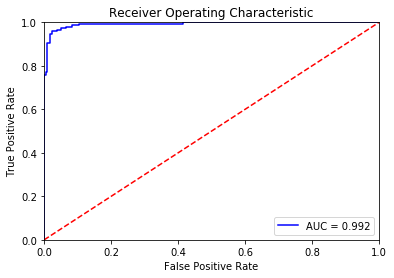

In [366]:
from sklearn.metrics import roc_curve, auc
# Here is some helpful code found on stack overflow
pred_proba = lm.predict_proba(result_x)
fpr, tpr, threshold = roc_curve(y_test == 'work', pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

Wow! 0.992 AUC_ROC. That is amazing. I think we can safely say we have created an extremely effective model for predicting procrastination.

#### Taking a deeper look at our features

In [367]:
# This bit of code is pulling out my features that have coefficients greater than zero
# Lasso regularization reduces the coef to 0 of the features (in our case unique ngrams)
import math
features =(vect.get_feature_names())
feature_dict = {}
for (i, f) in enumerate(features):
    if np.abs(lm.coef_[0][i]) > 0:
        feature_dict[f] = lm.coef_[0][i]

In [368]:
# For convienence sake I'll put the features into a data frame for easier exploration
feature_df = pd.DataFrame.from_dict(feature_dict, orient='index')
feature_df.columns = ['coef']

Let's take a quick look at the number of features and our total documents. We really do not want a model utilizing more features than we have documents. Our reguralization should have accounted for this, but it's not a bad idea to double check.

In [369]:
# How many documents do I have in my training set
print("Number of docs: " + str(len(X_train)))

# How many features do I have after reguralization
print("Number of features: " + str(len(feature_df)))

Number of docs: 728
Number of features: 168


In [344]:
# We can raise our logisitic regression coef to the e to calculate the odds ratio
feature_df['odds_ratio'] = feature_df['coef'].apply(np.exp)

Now let's look at what words are most associated with procrastination and productivity. We can sort our dataframe by odds ratio. The smaller odds ratio means words that are less related productivity, and a higher ratio means more related.

In [345]:
feature_df.sort_values('odds_ratio').head(10)

,coef,odds_ratio
game,-0.137337,0.871676
likes,-0.082925,0.920420
reddit,-0.078881,0.924150
photo,-0.063171,0.938783
attack,-0.057691,0.943942
src,-0.056463,0.945101
thwas,-0.055762,0.945764
video,-0.042215,0.958664
us,-0.041966,0.958902
5e,-0.038311,0.962414


In [343]:
feature_df.sort_values('odds_ratio', ascending=False).head(10)

,coef,odds_ratio
github,0.170815,1.186271
using,0.157641,1.170745
data,0.115566,1.122509
file,0.071850,1.074494
code,0.068924,1.071355
import,0.063022,1.065050
instagram,0.053534,1.054993
friction,0.052766,1.054183
stack,0.051788,1.053153
kurzgesagt,0.039332,1.040116


Looking at the top 10 words related to procrastinating I can see a lot of things that make sense. Words like 'game', 'reddit', 'photo' make sense in a general sense. '5e' and 'attack' look related to Dungeons and Dragons (I thing I spend a lot of time reading about). 'src', 'us', and 'thwas' I don't undrestand as much.

The top 10 words for being productive are almost all really clear to me. 'github' being the strongest indicator comes at no suprise, with 'data', 'file', 'code', and 'import' all following closely behind. The word 'using' is interesting. I do find myself googling phrases like "classifying data using logistic regression' quite frequently, perhaps that verb is largely prevelant in sentences for when I'm being productive. 'instagram' is another interesting word. I do not use instagram. I don't even have an account. But I did spend a long afternoon one day trying to figure out how to get their API to work for a project I was working on. 'Kurzgesagt' is the name of a Youtube channel for educational videos. I am extremely please to see it show up as an indicator of producitivity. That is a text book example of the kind of key word I was hoping to find that would distinguish mindless youtube videos from educational ones.

#### Investigating miss-classified events

I would like to better understand in what use cases my model miss-classified a website. What were the probabilities like? What kind of content was it trying to classifiy? To do that I'm going to need to write a little bit of exploritory code.

In [372]:
# I am going to create a score column. This is just going to be the probability mulitplied by 100.
X_test['prob_work'] = list(lm.predict_proba(result_x)[:,1]*100)

In [373]:
X_test['prob_work'] = list(X_test.prob_work.apply(int))
X_test['predict']  = list(lm.predict(result_x))

In [320]:
# Now let us look at what what value do not overlap in out test dataset
X_test[X_test.activity != X_test.predict]

,activity,text,timestamp,url,prob_work,predict
818,procr,AnyDice AnyDice Dice Probability C...,2017-7-27-11-0-51,,57,work
147,work,K-means Clustering : pystatsjump to contentMy ...,2017-7-25-19-59-3,,42,procr
495,procr,dnd 5e - Multiclass Warlock/Wizard: Can I use...,2017-7-24-10-22-3,,75,work
997,procr,[OC] snapchat heat map aligning with path of E...,2017-8-21-15-13-0,https://www.reddit.com/r/dataisbeautiful/comme...,63,work
389,procr,Python (genus) - Wikipedia ...,2017-8-5-3-23-47,,72,work
505,work,Dashboard ...,2017-8-22-14-40-40,https://git.generalassemb.ly/orgs/DSI-DC-5/das...,48,procr
427,work,Balances ...,2017-8-22-14-9-28,https://ebranch.nasafcu.com/HBNet/App/Account/...,48,procr
855,work,Python-written open source tool to transform e...,2017-7-25-19-52-37,,37,procr
860,procr,Dead-Baby Jokes about | contac...,2017-8-18-12-34-50,http://www.skrause.org/humor/deadbaby.shtml,50,work
806,work,(1) Intro to vectors & scalars | One-di...,2017-7-20-18-20-21,,34,procr


There is a lot to explore here. The one trend that I see immediately is that most of these miss-classifications do not have very confident scores. They all have scores somewhere between 25-75 with the exception of the last result. I need to investigate that last result further, but from what I can tell it appears that I may have pressed the wrong button when classifying the data.

In [378]:
# looking at the raw text of our miss-classified test data.
X_test.loc[611].text[0:2000]

'America\'s Pastimejump to contentMy Subreddits-Dashboard-home-popular-All-Random-Friends-Saved-edit|add shortcuts from the my subreddits menu at left or click the button by the subreddit name, drag and drop to sort↑↓>\uf139<\xa0baseballhotnewrisingcontroversialtopgildedwikipromoted   show images JustARegularGuy\xa0(825    ·    9,731)|messages0|preferences||logout\uf076limit my search to r/baseballSort:relevancenewhottopcomments Time:all timethis hourtodaythis weekthis monththis year[-]use the following search parameters to narrow your results:subreddit:subredditfind submissions in "subreddit"author:usernamefind submissions by "username"site:example.comfind submissions from "example.com"url:textsearch for "text" in urlselftext:textsearch for "text" in self post contentsself:yes (or self:no)include (or exclude) self postsnsfw:yes (or nsfw:no)include (or exclude) results marked as NSFWe.g. subreddit:aww site:imgur.com dogsee the search faq for details.advanced search: by author, subreddi

The raw text appears to be from the r/baseball subreddit which definitely was recorded while procrastinating. It is almost certianly mistakenly classified as being productive because of a misclick. There are likely many of these mistakes scattered throughout our training data as well. It is difficult to understand how manually miss-classified data is effecting our overall result, but for the sake of brevity we are going to consider this event an outlier that we cannot address.

I am more interested in the other events, and how frequenty we get probabilities with similar scores to the miss-classified scores (the range between 25-75). This might be best explored with a visualization.

In [ ]:
# Let's start by classifying what percent of our data falls in this danger zone.
len(X_test[(X_test.prob_work <=75) & (X_test.prob_work >= 25)])/len(X_test)

Just under 20% of our data is in this unclear zone. I'd like to compare the accuracy of the data in this mid zone to the accuracy of our data in the edge region.

In [393]:
mid_zone = X_test[(X_test.prob_work <=75) & (X_test.prob_work >= 25)]
good_zone = X_test[(X_test.prob_work >75) | (X_test.prob_work < 25)]

In [396]:
# Some quick math to compare the amount of data in each zone (really just double checking here)
print("Number in good zone: " + str(len(good_zone)))
print("Number in mid zone: " + str(len(mid_zone)))

Number in good zone: 292
Number in mid zone: 67


In [401]:
print("Accuracy good_zone: " + str(1 - len(good_zone[good_zone.activity != good_zone.predict])/len(good_zone)))

Accuracry good_zone: 0.9965753424657534


In reality this value should be 100, because as we discussed earlier this data was manually mis-classified and the model actually predicted it correctly.

In [402]:
print("Accuracy mid_zone: " + str(1 - len(mid_zone[mid_zone.activity != mid_zone.predict])/len(mid_zone)))

Accuracry mid_zone: 0.835820895522388


This is more interesting. When we do not have a strong predictor our accuracy falls pretty significantly. We could almost consider introducing a 3rd category into our classification; a category for unsure. Even though we are still respectively accurate in this mid zone. Out of curioustiy what is the baseline for these respective regions.

In [405]:
# Caluclating our baseline for good zone
print("Baseline good_zone: " + str((good_zone.activity == 'work').sum()/float(len(good_zone))))
print("Baseline mid_zone: " + str((mid_zone.activity == 'work').sum()/float(len(mid_zone))))

Baseline good_zone: 0.373287671233
Baseline mid_zone: 0.537313432836


AttributeError: module 'matplotlib.pyplot' has no attribute 'ylabel'

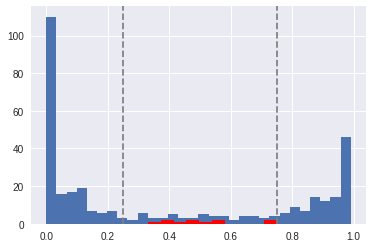

In [514]:
# Correcting the bad data point
X_test.set_value(611, 'activity', 'procr')

good = X_test[X_test.activity ==X_test.predict]
bad = X_test[X_test.activity !=X_test.predict]
plt.hist(good.prob_work/100, bins=30,alpha=1)
plt.hist(bad.prob_work/100, alpha=1, color='red')

plt.axvline(x=.25, color='grey', linestyle='--')
plt.axvline(x=.75, color='grey', linestyle='--')
plt.ylabel("Test")
plt.title("Predicted Probabilities for Classified and Missclassified Data")

The results from my initial run through have been extremely successful. I have a f7unctioning model with above a 95% accuracy. My base line is about 60% so this is a large improvement. I have used logistic regression with regularization to get my intial results, but I have some concerns about that approach.

I currently have 105000 features wiht non-zero coefficients. This is vastly more than the number of documents I have in my training set (~700). I have discussed several approaches to solving this issue. One, is that my model is surviving a train test split. It is accurate, despite having the potential to be over fitted. I think the reguralization is doing it's part. Nonetheless, I am going to try to reduce the number of features and see how much my accuracy is actually impacted.

Secondly I want to try different modeling methods. It has been suggested that I use and SVM. I will also try a random forest, given that they handle large numbers of features well.

Finally, I would like to do some more exploration of what features are correlated with what URLs. I have some artificat features that don't correlate with real words. I want to know if they only show up on certain websites, or if they exist accross multiple websites.

All in all, my model is in good shape. I have a strong predictability. I will spend some time doing additional exploration, but overall I think I am in good shape. I need to make some additional visualizations for my presentation (I have several in mind).